In [10]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

## Use decision tree as a rough way for splitting based on that feature
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn import tree

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

from constants import regions

In [3]:
t1 = time.time()

# 1 Data type is defined by script input ______________________________________________________
data_types = ['N2', 'N3','REM', 'Wake', 'N1']
expt_nums = [1,2]

max_scores = []

for data_type in ['N2', 'N3','REM', 'Wake', 'N1']:
    for expt_num in expt_nums:
        for region in regions:
            try:
                # f_name =  'Results/' + data_type + '_expt_' + str(expt_num) + '_scores.pkl'
                f_name =  'Results/Three_Search/' + data_type + '_' + region +  '_expt_' + str(expt_num) + '_scores.pkl'
                scores = joblib.load(f_name)
                max_score = np.array(scores).max()
                max_scores.append( (max_score, f_name) )
            except:
                pass
        # f_name =  'Results/' + data_type + '_expt_' + str(expt_num) + '_col_combos.pkl'
        # coL_combos = joblib.load(f_name)

t2 = time.time()

t2-t1

354.6082534790039

In [11]:
max_scores_fname = 'Results/Three_Search/max_scores.pkl'
# joblib.dump(max_scores, max_scores_fname)
max_scores_loaded = joblib.load(max_scores_fname)

In [12]:
highest_scores = []
for (score, file_name) in max_scores_loaded:
    if score > 0.90 : 
        highest_scores.append( (round(score,3),file_name) )
highest_scores

[(0.902, 'Results/Three_Search/N2_Frontal_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N2_Right Frontal_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N2_Central_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N2_Left Central_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N2_Right Central_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N2_Left Temporal_expt_1_scores.pkl'),
 (0.927, 'Results/Three_Search/N2_Right Temporal_expt_1_scores.pkl'),
 (0.927, 'Results/Three_Search/N2_Parietal_expt_1_scores.pkl'),
 (0.927, 'Results/Three_Search/N2_Left Parietal_expt_1_scores.pkl'),
 (0.927, 'Results/Three_Search/N2_Occipital_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N3_Left Parietal_expt_1_scores.pkl'),
 (0.902, 'Results/Three_Search/N3_Occipital_expt_1_scores.pkl'),
 (1.0, 'Results/Three_Search/Wake_Left Frontal_expt_1_scores.pkl'),
 (0.933, 'Results/Three_Search/Wake_Right Frontal_expt_1_scores.pkl'),
 (0.933, 'Results/Three_Search/Wake_Left Central_expt_1_sc

#### Load a file to plot

In [59]:
f_name_scores = 'Results/Three_Search/N1_Left Temporal_expt_1_scores.pkl'
f_name_col_combos = 'Results/Three_Search/N1_Left Temporal_expt_1_col_combos.pkl'

scores = joblib.load(f_name_scores)
col_combos = joblib.load(f_name_col_combos)

top_col_combos = [list(val) for val in np.array(col_combos)[ list(np.array(scores).argsort())[-40:] ] ]
top_scores= [score for score in np.array(scores)[ list(np.array(scores).argsort())[-40:] ] ]

In [60]:
top_scores[-1]

0.95

In [61]:
top_col_combos[-1]

['16.0_width_6', '4.5_width_7', '15.5_width_1']

In [62]:
# Create a new list based on breaking on the underscore 
# Turn them to floats 
# Turn them to array 
# Arg sort the array
# Use argsorted array to sort the original list

ordered_top_col_combos = []
for c in top_col_combos: 
    low_to_high_ind_ordering = list( np.array( [float(item.split('_')[0]) for item in c] ).argsort() ) 
    ordered_combo = [ c[i] for i in low_to_high_ind_ordering ]
    ordered_top_col_combos.append(ordered_combo)
    
ordered_top_col_combos[:5]

[['4.0_width_6', '14.0_width_9', '37.5_width_2'],
 ['4.5_width_7', '15.5_width_10', '38.75_width_0.5'],
 ['4.5_width_7', '14.5_width_6', '36.5_width_2'],
 ['4.5_width_7', '14.5_width_6', '37.0_width_2'],
 ['4.5_width_7', '15.75_width_0.5', '16.0_width_6']]

#### Load the PSD and calculate features

In [63]:
expt_num = 1
data_type = 'N1'
region = 'Left Temporal'
df = joblib.load(os.path.join(os.path.abspath('..'), data_type + '_psd_normalised_data.pkl') )

single_region_df = df[[col for col in df.columns if col.endswith('_' + region)]]
frequency_vals  = np.arange(0.5,40.125, 0.125)
single_region_df.columns = frequency_vals

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})

In [64]:
width_slide_list = [(0.5,0.5)] 
for window_width in range(1, 15 ):
    width_slide_list.append((window_width, 0.5) )

In [65]:
t3 = time.time()

results_dfs = []
feature_dfs = []

j = 0 #counter to populate feature dict dataframes

for window_width_hz, window_slide_hz in width_slide_list:
    description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
    
    #1.Set Window width in Hz and Window Slide in Hz
    # window_width_hz = 3
    window_len = (window_width_hz/0.125)+1
    assert window_len%1 == 0
    window_len = int(window_len)
    
    # window_slide_hz = 0.5 
    window_slide_len = window_slide_hz/0.125 
    assert window_slide_len%1 == 0
    window_slide_len = int(window_slide_len)
    
    
    #2.Calculate band values and store in dataframe calculated_df
    
    # Start of the window is the middle_freq value minus window_width_hz/2 
    # End of the window is the middle freq value plus window_width_hz/2
    window_len
    
    middle_freq = []
    final_cols = []
    
    i = 0
    while i < len(frequency_vals) - window_len:
        middle_freq.append( frequency_vals[i:i+window_len].mean() )
        band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
        
        final_cols.append(band_vals)
        
        # scaled_psd.append( psd_values[i:i+factor].mean() )
        i+= window_slide_len
    
    calculated_df = pd.DataFrame(final_cols).T
    calculated_df.columns = middle_freq
    
    calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
    
    
    #3.Calculate Information Gain Based on Features
    #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
    
    X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)

    feature_dfs.append(X_expt)

X_expt_concatenated = pd.concat(feature_dfs, axis=1)

t4 = time.time()
t4-t3

0.4365701675415039

##### Scatter plot features with the best scores

In [66]:
# top_col_combos top_scores X_expt_concatenated
top_col_combos[-1]

['16.0_width_6', '4.5_width_7', '15.5_width_1']

In [67]:
for key in data.keys():
    print(len(data[key]))

30
30
30
30
30


In [69]:
num = -1
data = {
    'x': X_expt_concatenated[top_col_combos[num][0] ],
    'y': X_expt_concatenated[top_col_combos[num][1] ] ,
    'z': X_expt_concatenated[top_col_combos[num][2] ],
    'size': [1 for i in range(len(y_expt))],
    'color': y_expt,
    }
df = pd.DataFrame(data)

fig = px.scatter_3d(df,
                    x='x',
                    y='y',
                    z='z',
                    color='color',
                    size='size',
                    title='plotly',
                    opacity=0.8,
                    color_continuous_scale='viridis',
                    )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))

fig.write_html('filename.html')

fig.show()

#### Plotly Example Plot

In [ ]:
import plotly.express as px

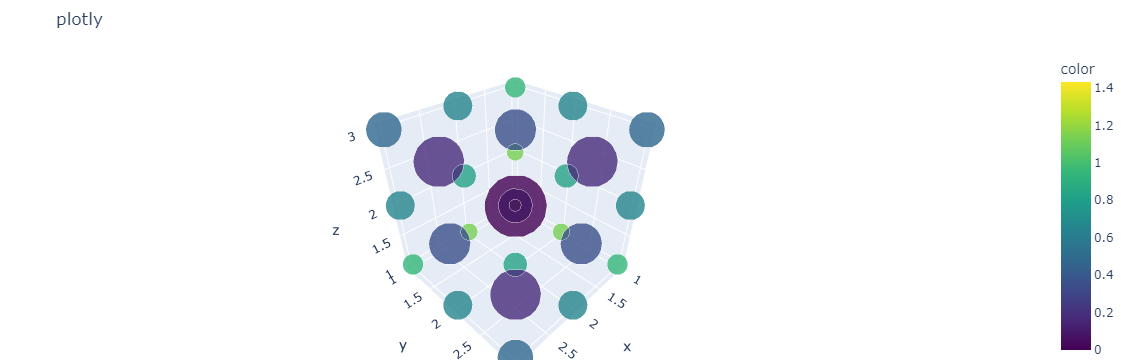

In [26]:
data = {
    'x': [],
    'y': [],
    'z': [],
    'size': [],
    'color': [],
    }

side = 3

for x in range(1, side+1):
    for y in range(1, side+1):
        for z in range(1, side+1):
            size = (x * y * z / side**3) * 100
            color = np.log10((side**3)/(x * y * z))
            data['x'].append(x)
            data['y'].append(y)
            data['z'].append(z)
            data['size'].append(size)
            data['color'].append(color)

df = pd.DataFrame(data)

fig = px.scatter_3d(df,
                    x='x',
                    y='y',
                    z='z',
                    color='color',
                    size='size',
                    size_max=df['size'].max(),
                    title='plotly',
                    opacity=0.8,
                    color_continuous_scale='viridis',
                    )

fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))

fig.write_html('filename.html')

fig.show()